<p style="margin: 0; text-align:right;">2022-2 · Master universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informatica, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


### Modelos generativos

En esta práctica implementaremos uno de los tipos de modelos generativos más utilizados actualmente, las redes generativas adversarias, ie. **GANs**.



El objetivo de esta PEC es comprender la implementación de una solución generativa, utilizando DCGANs para la generación de imágenes, mediante el conjunto de datos de referencia en deep learning más sencillo existente: MNIST.



In [15]:
import numpy as np
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

# 1. Obtención de los datos

El código para cargar los datos es el siguiente:

In [16]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Añade un comentario explicativo, a cada una de las líneas de código de abajo, indicando cuál es su funcionalidad.</div>

**Respuesta**:

* `latent_dim = 100`: Es la dimensión del espacio latente, el cual es de menor dimensión que los datos originales y su objetivo es capturar los patrones o estructura subyacentes en los datos para representarlos de forma comprimida y abstracta. En el caso de las GANs, el generador sabe cómo convertir un punto del espacio latente en una imagen (preferiblemente similar al conjunto de datos en el que se entrenó). En este caso, la dimensión latente del modelo generativo o el tamaño de entrada del generador se establece en 100. Entonces, la red del generador toma un vector de entrada aleatorio de tamaño 100 del espacio latente y lo transforma en una muestra de salida

* `img_rows, img_cols = 28, 28`: Con esta linea se define el tamaño de las imágenes tanto en ancho (img_cols) como en alto (img_rows)
* `img_channels = 1`: Con esta linea se define la cantidad de canales que representarán los colores de las imágenes, en este caso se indica 1, por lo tanto las imagenes serán en escala de grises.

* `(x_train, _), (_, _) = mnist.load_data()`: Esta linea carga el conjunto de datos MNIST utilizando la función mnist.load_data(). El conjunto de datos MNIST consiste de un conjunto de imágenes de dígitos escritos a mano. Devuelve cuatro conjuntos de datos: imágenes de entrenamiento (x_train), etiquetas de entrenamiento (que no se usan y se descartan con _), imágenes de prueba (que no se usan y se descartan con _) y etiquetas de prueba (que no se usan y se descartan con _). _)

* `x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)`: Esta linea remodela el conjunto de datos x_train para que coincida con la forma de entrada deseada para la red neuronal. El x_train.shape[0] representa el número de muestras de entrenamiento. Remodela el conjunto de datos para que tenga dimensiones [número de muestras, img_rows, img_cols, img_channels].

* `x_train = x_train.astype('float32')`: Esta linea convierte el tipo de datos del conjunto x_train del tipo de entero predeterminado a un tipo de punto flotante de 32 bits.

* `x_train /= 255`: Esta linea normaliza los valores de píxel del conjunto de datos x_train. Dado que los valores de píxeles en las imágenes varían de 0 a 255 (escala de grises de 8 bits), dividirlos por 255 escala los valores entre 0 y 1. La normalización ayuda a lograr una mejor convergencia durante el entrenamiento y garantiza que todas las entidades de entrada tengan una escala similar.

## 2. Implementación del Generador

A continuación se muestra una propuesta de generador:

In [17]:
def generator_model(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Contesta a las preguntas siguientes:
</div>

**1. ¿Cuál es la finalidad del generador?:**

Su finalidad es generar nuevas instancias del mismo dominio que el conjunto de datos de origen, es decir generar muestras realistas y de alta calidad que se parezcan a los datos de entrenamiento. En otras palabras, el objetivo del generador es generar datos sintéticos que no se pueden distinguir de los datos reales de forma de que el discriminador no pueda diferenciarlos.

**2. Investigar por qué se utiliza `Upsampling` en las dos primeras capas en lugar de la `Conv2DTranspose` propuesta en DCGAN. Dar una justificación:**

El uso de la capa Upsampling antes de la capa Conv2DTranspose es una técnica utilizada en modelos generativos para generar imágenes realistas y de mayor calidad. El objetivo de la capa de Upsampling es aumentar la resolución espacial de los datos y mejorar la calidad de la salida generada. El generador toma ruido aleatorio o variables latentes como entrada y su objetivo es generar muestras realistas que se asemejen a los datos de entrenamiento. La capa Conv2DTranspose es responsable de aumentar el muestreo de la entrada y transformarla en una salida de mayor resolución. Pero, en algunos casos, el uso de Conv2DTranspose sola puede generar ciertos artefactos o pérdida de detalles finos en las imágenes generadas. Para solucionar esto es que se añade una capa Upsampling antes de la capa Conv2DTranspose. La capa Upsampling aumenta las dimensiones espaciales de los datos mediante distintas técnicas, como interpolación o vecinos más cercanos. Al aumentar el muestreo, la resolución de los mapas de características aumenta lo que permite que el generador capture detalles más finos y genere resultados de mejor calidad.

**3. ¿Por qué se utiliza la normalización entre capas?**

La capa BatchNormalization tiene como objetivo principal mejorar la estabilidad y el rendimiento de la red neuronal durante el entrenamiento. Opera en un lote de entrada y lo normaliza para tener media cero y varianza unitaria.  Al normalizar las entradas de cada capa, la normalización por lotes ayuda a reducir el problema de desaparición/explosión del gradiente, permitiendo una convergencia más estable y rápida.
Otro problema que ayuda a resolver la normalización entre capas es el cambio de covariable interno que ocurre cuando la distribución de las entradas de la capa cambia durante el entrenamiento, lo que dificulta que la red aprenda de manera efectiva, la normalización por lotes soluciona este problema al normalizar las entradas de cada capa, ayudando a que la red sea más resistente a los cambios en la distribución de entrada. 
Al estabilizar el proceso de entrenamiento interno, la normalización ayuda a mejorar el flujo del gradiente a través de la red, es decir permite una retropropagación más eficiente, lo que a su vez conduce a un mejor aprendizaje y optimización.
En el modelo que tenemos aquí, la capa de normalización se aplica justo antes de cada capa de activación, ayudando a mantener las activaciones estables, preservar la información, mejorar la convergencia y proporcionar regularización. Todo esto contribuye a la eficacia y rendimiento del modelo durante el entrenamiento y la generación de muestras de alta calidad.

**4. ¿Qué funciones de activación se utilizan? ¿Cuál es la razón de la sigmoide en la última capa?**

En la capa de activación pueden usarse distintas funciones de activación dependiendo los requerimientos del modelo y del problema que se intenta resolver, algunos ejemplos son:
    
    - ReLU (Unidad Lineal Rectificada): Establece todos los valores negativos a cero y deja los positivos sin cambios. Es computacionalmente eficiente y ayuda a mitigar el problema del gradiente. En el modelo del generador que tenemos aquí, se utiliza esta función en las capas intermedias, ReLU apermite que el generador aprenda mapeos complejos desde el espacio latente hasta el mapa de características de mayor dimensión. Lo ayuda a capturar y ampliar las características relevantos en los datos, ayudandolo a generar imágenes más diversas y detalladas.
    
    - LeakyReLU: Es una variación de la anterior, introduce una variación que es una pequeña pendiente negativa para valores negativos, al permitir valores negativos pequeños ayuda a abordar los puntos donde la función anterior puede  volverse intactiva.
   
    - Tanh (tangente hiperbolica): Ajusta los valores de entrada entre -1 y 1, proporcionando un rango de valores tanto positivos como negativos. 
    
    - Softmax: Se utiliza a menudo en la capa de salida de problemas de clasificaci'on de múltiples clases. Normaliza las probabilidades de salida para que sumen 1, lo que permite que el modelo asigne probabilidades a varias clases. 
    
    - Lineal: Función lineal o de identidad, simplemente devuelve el valor de entrada sin ninguna transformación, se usa comunmente en tareas de regresión o cuando el modelo necesita aprender relaciones lineales.
    
    - Sigmoid: Se utiliza particularmente en problemas de clasificación binaria. Asigna a la entrada un rango de [0,1] lo cual lo hace adecuado para tareas en las que la salida representa probabilidades o decisiones binarias. 
    En el modelo de generador que tenemos aquí, en la última capa de activación se usa una función sigmoid con el objetivo de que la salida del generador tenga valores entre 0 y 1, lo cual representa la intensidad de la escala de grises de cada píxel de la imagen generada. 
    Es importante el uso de la capa sigmoidea en la última capa para garantizar que las imagenes generadas tengas intensidades de pixeles en el rango adecuado.

## 3. Implementación del Discriminador

A continuación se muestra el discriminador propuesto

In [18]:
# (W−F+2P)/S+1
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Contesta a las preguntas siguientes:
</div>


**1. ¿Cuál es la finalidad del discriminador?:**

La función del discriminador es distinguir entre datos reales y generados. El discriminador actúa como un clasificador binario, entrenado para clasificar las muestras de entrada como reales o falsas. Entonces el generador genera datos sintéticos, como imágenes en este caso, y el discriminador evalúa los datos generados y proporciona retroalimentación al generador, en este sentido podemos mencionar que el discriminador guia el proceso de aprendizaje del generador asegurando que los datos que va generando sean cada vez más realistas.  

**2. ¿Cuáles son las dimensiones de los tensores y características de las variables de entrada y salida del discriminador? :**

    - Tensor de entrada: La forma del tensor de entrada es (img_rows, img_cols, img_channels), donde img_rows es la altura de la imagen de entrada, img_cols es el ancho de la imagen de entrada e img_channels es el número de canales en la imagen de entrada. En este caso en particular el tamaño de los datos de entrada será: (28,28,1).
    
    - Capas convolucionales: El discriminador utiliza varias capas convolucionales con diferentes profundidades o número de filtros. La profundidad comienza en 64 y se multiplica por dos para cada capa posterior. Utilizan un kernel de tamaño (5,5) y tienen un stride (paso) de 2, con excepción de la última que tiene stride = 1. El padding se setea en 'same' lo cual significa que las dimensiones espaciales de entrada y salida son iguales.
    
    - Capas LeakyReLU: Seteadas con un alpha = 0.02, permiten la propagación de pequeños valores negativos para evitar el problema de 'muerte de las neuronas ReLU' que ocurre cuando la función las neuronas ReLU siempre emiten 0 para cualquier entrada y no contribuyen al proceso de aprendizaje, lo cual sucede cuando una gran cantidad de neuronas terminan en el estado saturado, donde la suma ponderada de las entradas es negativa y la función la mapea como cero. Una vez que la neurona "muere" es poco probable que se recupere durante el entrenamiento ya que sus gradientes permanecen en cero y no puede actualizar sus pesos.
    
    - Capas dropout: Se aplica regularización con capas de dropout, esta capa establece aleatoriamente una fracción de las unidades de entrada a 0 durante el entrenamiento para evitar el sobre entrenamiento.
    
    - Capa de salida: Es una capa totalmente conectada (Dense) con una sola unidad. Produce una puntuación de probabilidad unidimensional que indica la probabilidad de que la imagen de entrada sea real o falsa, la función de activación en esta capa es sigmoide, para asignar a la salida el rango entre 0 y 1. 
    
    - Capa Flatten: Antes de la capa de salida se utiliza una capa flatten para convertir los mapas de características 2D de las capas convolucionales anteriores en vectores de características 1D. 
    
    En conclusión, el discriminador toma una imagen de entrada de forma (img_rows, img_cols, img_channels) y produce una única puntuación que indica la probabilidad de que la entrada sea real o falsa.
    
    
**3. ¿Cuál es la diferencia con una CNN habitual?**

Una CNN se utiliza principalmente para tareas de aprendizaje, como la clasificación de imágenes, la detección de objetos y la segmentación. Está diseñada para aprender y extraer características de los datos de entrada para hacer predicciones o clasificaciones. En cambio una GAN es un marco de aprendizaje no supervisado que consta de dos redes neuronales en competencia, un generador y un discriminador, que tienen como objetivo generar datos sintéticos que se asemejen a la distribución de datos reales, como imágenes, audio o texto realistas.
Dada esta diferencia entre ambas redes neuronales, la forma de entrenamiento de ellas también varía, las CNN suelen entrenarse de manera supervisada, donde la red se presenta con datos de entrenamiento etiquetados y su objetivo es minimizar una función de pérdida, ajustando los parámetros de la red mediante retropropagación y descenso del gradiente. Las GANs, por otro lado, tienen otra estrategia, el generador y el discriminador se entrenan iterativamente de manera competitiva. El generador tiene como objetivo generar datos que engañen al discriminador, mientras que éste tiene como objetivo clasificar con precisión los datos reales y falsos. Este proceso de entrenamiento implica actualizar los parámetros de las redes en función de los gradientes calculados a partir de la retroalimentación del discriminador.

**4. ¿Qué funciones de activación se utilizan?**

En el discriminador de aquí las funciones de activación que se utilizan son LeakyReLU y Sigmoid.

    - Leaky ReLU: se utiliza después de cada capa convolucional. Como mencioné antes, introduce una pequeña pendiente negativa para entradas negativas evitando que las neuronas "mueran" por completo y permitiendo el flujo de gradientes durante la retropropagación.
    
    - Sigmoid: Se utiliza en la capa final. Ajusta la salida en un rango entre 0 y 1. La salida se interpreta como la probabilidad de que la imagen que recibe el discriminador sea falsa (cercano a 0) o real (cercano a 1).

**5. ¿Cuál es la finalidad del dropout que encontramos en las capas?**

El objetivo de la capa DropOut es evitar el sobre entrenamiento y mejorar la capacidad de generalización de la red. 
El sobre entrenamiento se da cuando una red se vuelve muy especializada en los datos de entrenamiento y no logra generalizar bien los datos que no ha visto. La capa de DropOut ayuda a evitar eso eliminando aleatoriamente (es decir ajustando a cero) una fracción de las entradas durante el entrenamiento. 

En este modelo, la capa DropOut se aplica después de cada capa convolucional y de la activación LeakyReLU. al eliminar entradas de forma aleatoria, el DropOut evita que el discriminador confie demasiado en activaciones o características específicas. Lo cual lleva a la red a aprender representaciones más sólidas y generalizables. La capa DropOut actúa como una especie de regularización, reduciendo las posibilidades de sobre entrenamiento y mejorando la capacidad de discriminador para generalizar datos nuevos.


# 4. Modelo GAN



**1. A qué llamamos modelo GAN y por qué recibe ese nombre?:**

Los modelos GAN reciben ese nombre por Redes Antagónicas Generativas o Redes Adversarias Generativas. Son un método para la optimización competitiva entre dos redes neuronales, una llamada generadora y otra discriminadora, con el objetivo de generar nuevas instancias de datos idealmente indistinguibles a las pertenecientes a la distribución de probabilidad de la que derivan los datos de entrenamiento.  
La red generadora se encarga de generar nuevas instancias del mismo dominio que el del conjunto de datos de origen y la red discriminadora se encarga de discriminar si los datos de entrada son reales, es decir pertenecientes al conjunto de datos de entrada o si son ficticios, es decir generador artificialmente. Ambas redes se entrenan de manera de manera conjunta de manera que G maximice sus posibilidades de no ser detectada por D y D de forma que haga cada vez más sofisticados sus métodos de detección de los datos generados artificialmente por G.
Estas dos redes adversarias compiten en un juego de suma cero en el que se hipotetiza que eventualmente llegan a un equilibrio de Nash.

## 4.1 Modelo Discriminador

**1. ¿Qué función de pérdida utiliza el discriminador? ¿Por qué? :**

El discriminador utiliza la función de pérdida: binary_crossentropy, la cual es adecuada para tareas de clasificación binaria, lo cual es justamente el objetivo del discriminador en una GAN.
Su rol es distinguir entre datos reales y falsos. Toma muestras de entrada y predice la probabilidad de que la entrada sea real o falsa, lo cual es una tarea de clasificación entre dos clases: real (1) y falsa (0). 
La función de pérdida binary_crossentropy mide la diferencia entre las probabilidades predichas y las etiquetas verdaderas. Calcula la pérdida comparando la salida pronosticada con las etiquetas binarias verdaderas (0,1) y penaliza el modelo en función de la diferencia entre ambas.

**2. Busca en la bibliografía la razón por la que se propone utilizar `RMSProp` como optimizador en vez de otros.**

La razón por la que se utiliza este optimizador es porque proporciona una técnica para evitar el problema de explosión o desaparición del gradiente, mediante el uso de un promedio móvil de gradientes cuadrados para normalizar el gradiente. Esta normalización ayuda a mantener un tamaño de paso equilibrado durante la optimización, siendo el paso lo que determina cuánto se actualizan los parámetros de cada iteración. Un tamaño de paso más grande equivale a una actualización de parámetros más significa, lo que significa que los parámetros cambiarán más rápido. Por el contrario, un tamaño de paso más pequeño conduce a actualizaciones más graduales. RMSProp, adapta el tamaño del paso para cada parámetro en función de la magnitud de sus gradientes, lo cual ayuda a equilibrar las actualizaciones. Específicamente, disminuye el tamaño de paso para gradientes grandes,  evitando que exploten, mientras que aumenta el tamaño de paso para gradientes pequeños para evitar que desaparezcan. 
Entonces, RMSProp no trata la tasa de aprendizaje como un parámetro fijo sino que la adapta dinámicamiente a medida que avanza la optimización. Al ajustar la tasa de aprendizaje en función de las características de los gradientes, RMSProp tiene como objetivo mejorar la estabilidad y la eficiencia del proceso de entrenamiento.

**3. ¿Cuál es la razón de utilizar decay?**

El parámetro decay se refiere a la tasa de caida aplicada al promedio móvil de los gradientes al cuadrado. Controla la velocidad a la que se actualiza ese promedio móvil. Un valor más pequeño permite que el optimizador reacciones más rápido a los gradientes nuevos, mientras que un valor más grande hace que el optimizador dependa más de los gradientes anteriores.
Es decir, el propósito de usar este parámetro en el optimizador RMSProp es controlar la influencia de los gradientes anteriores en la actualización actual. Afecta la adaptabilidad de la tasa de aprendizaje al determinar cuánto peso de le da a los gradientes recientes frente a los anteriores.


In [19]:
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0002, decay=6e-8), 
                      metrics=['accuracy'])

In [20]:
generator = generator_model()

## 4.2 Modelo adversario

El modelo adversario es únicamente el generador-discriminador apilados juntos. Los parámetros de entrenamiento son los mismos que en el modelo Discriminador, salvo por una tasa de aprendizaje reducida y la correspondiente disminución del peso.

In [21]:
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=3e-8), 
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model

In [22]:
adversarial = adversarial_model()

## 4.3 Entrenamiento

In [23]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, latent_dim])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

Primero determinamos si el modelo de discriminador es correcto entrenándolo solo con imágenes reales y falsas. Después, los modelos Discriminador y Adversario entrenan uno tras otro.

In [24]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_dim])
        for epoch in range(train_epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # select a random half of images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
            
            # sample noise and generate a batch of new images
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generator.predict(noise)
            
            # train the discriminator (real classified as ones and generated as zeros)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # train the generator (wants discriminator to mistake images as real)
            y = np.ones([batch_size, 1])
            a_loss = adversarial.train_on_batch(noise, y)
            
            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))



**1. ¿Cuál es la finalidad de `noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])`? ¿Por qué estas dimensiones?**

La finalidad de esa línea es generar vectores de ruido aleatorio que sirven como entrada al modelo generados durante el entrenamiento. En las redes adversas generativas, el modelo generador toma ruido aleatorio como entrada y genera muestras sintéticas que se asemejan a los datos reales. El ruido actúa como una fuente de aleatoriedad que le permite al generador producir salidas diversas y variadas.

En este caso, se generan números aleatorios a partir de una distribución uniforme entre -1 y 1. La matriz de ruido resultante tiene una forma de: [batch_size, latent_dim], donde batch_size corresponde al número de vectores de ruido generados y laten_dim representa la dimensionalidad de los vectores de ruido.

El generador recibe un número batch_size de vectores de ruido, cada uno de estos vectores con dimensionalidad latent_dim, y los utiliza para generar un lote de muestras sintéticas.
Al generar estas muestras a partir de una distribución uniforme continua en el rango de -1 a 1, el modelo garantiza que la entrada al generador cubra un espacio amplio y continuo. ayudando a garantizar la diversidad en las muestras generadas.

**2. ¿Cuál es la finalidad de `images_fake = generator.predict(noise)`?**

La finalidad de esa linea es la generación de imágenes sintéticas aplicando el modelo del generados a la entrada de ruido que mencionamos antes. La función generator.predict() aplica el modelo del generador a la entrada de ruido que se proporciona y produce las salidas correspondientes que son las muestras sintéticas.
La matriz images_fake generada contiene estas nuevas imágenes generadas por el generador y tiene dimensiones: [batch_size, image_height, image_width, image_channels] donde batch_size representa el número de imágenes sintéticas generadas, y los demás corresponden a las dimensiones de las imágenes. 

**3. ¿Cuál es la finalidad del código que sigue?**
```python
x = np.concatenate((images_train, images_fake))
y = np.ondas([2*batch_size, 1])
y[batch_size:, :] = 0
```

El objetivo del código es la generación de los datos de entrenamiento para el discriminador combinando imagenes reales con las imagenes generadas por el generador y la asignación de las etiquetas correspondientes, ya que el discriminador actúa como un clasificador (entre real o falso).
En primer lugar se genera el array x de datos, el cual tendrá un tamaño de (2*batch_size, image_height, image_width, image_channels), ya que primero contiene todas las imágenes reales y luego las generadas por el generador.
Luego se genera el array y de unos, es decir todas las etiquetas están seteadas a 1 en este punto, indicando que todas las imagenes son reales.
En la última línea, se asigna la etiqueta 0 (falso) a la segunda mitad del array, que corresponde a las imágenes falsas generadas por el generador.

**4. ¿Qué realiza el comando `d_loss = discriminator.train_on_batch(x, y)`? ¿Qué devuelve?**

Esa linea se usa para realizar un paso de actualización en el modelo discriminador usando los datos creados anteriormente x e y. Calcula la pérdida y actualiza los pesos del modelo en función de los gradientes calculados. 

La función train_on_batch devuelve una lista de dos valores:
El primero d_loss[0] representa el valor de pérdida calculado para el lote actual de muestras de entrenamiento Indica que tan bien se desempeña el discriminador en distinguir entre imagenes reales y falsas.
El segundo valor d_loss[1] representa la precisión del discriminador en el lote actual de muestras de entrenamiento. Indica el porcentaje de muestras correctamente clasificadas.

**5. ¿Qué realiza el comando `a_loss = adversarial.train_on_batch(noise, y)`? ¿Qué devuelve?**

Este comando se utiliza para hacer un paso de actualización en el modelo adversario (combinación de generador y discriminador) usando el ruido de entrada proporcionado y las etiquetas. 
Calcula la pérdida y actualiza los pesos del modelo en función de los gradientes calculados.

La función train_on_batch devuelve los mismos valores mencionados arriba: 
a_loss[0] representa el valor de pérdida calculado para el lote actual de muestras de ruido. Indica qué tan bien se desempeña el modelo adversario en la generación de imágenes realistas que pueden engañar al discriminador.
a_loss[1] representa la precisión del modelo adversario en el lote actual. Indica la proporción de muestras correctamente clasificadas (generadas como reales) por el discriminador. Una precisión más alta para el modelo adversario significa que está generando imágenes que son más realistas y pueden engañar mejor al discriminador para que las clasifique como reales.

In [25]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

8/8 [==============================] - 0s 3ms/step
0: [D loss: 0.641600, acc: 0.589844]  [A loss: 0.643688, acc: 0.644531]
8/8 [==============================] - 0s 3ms/step
1: [D loss: 0.648341, acc: 0.580078]  [A loss: 1.159408, acc: 0.019531]
8/8 [==============================] - 0s 3ms/step
2: [D loss: 0.632910, acc: 0.636719]  [A loss: 0.765706, acc: 0.382812]
8/8 [==============================] - 0s 3ms/step
3: [D loss: 0.599605, acc: 0.697266]  [A loss: 1.058722, acc: 0.089844]
8/8 [==============================] - 0s 3ms/step
4: [D loss: 0.611533, acc: 0.666016]  [A loss: 0.715908, acc: 0.488281]
8/8 [==============================] - 0s 3ms/step
5: [D loss: 0.603328, acc: 0.683594]  [A loss: 1.331691, acc: 0.015625]
8/8 [==============================] - 0s 3ms/step
6: [D loss: 0.626022, acc: 0.615234]  [A loss: 0.526454, acc: 0.808594]
8/8 [==============================] - 0s 3ms/step
7: [D loss: 0.687756, acc: 0.566406]  [A loss: 1.418407, acc: 0.000000]
8/8 [===========

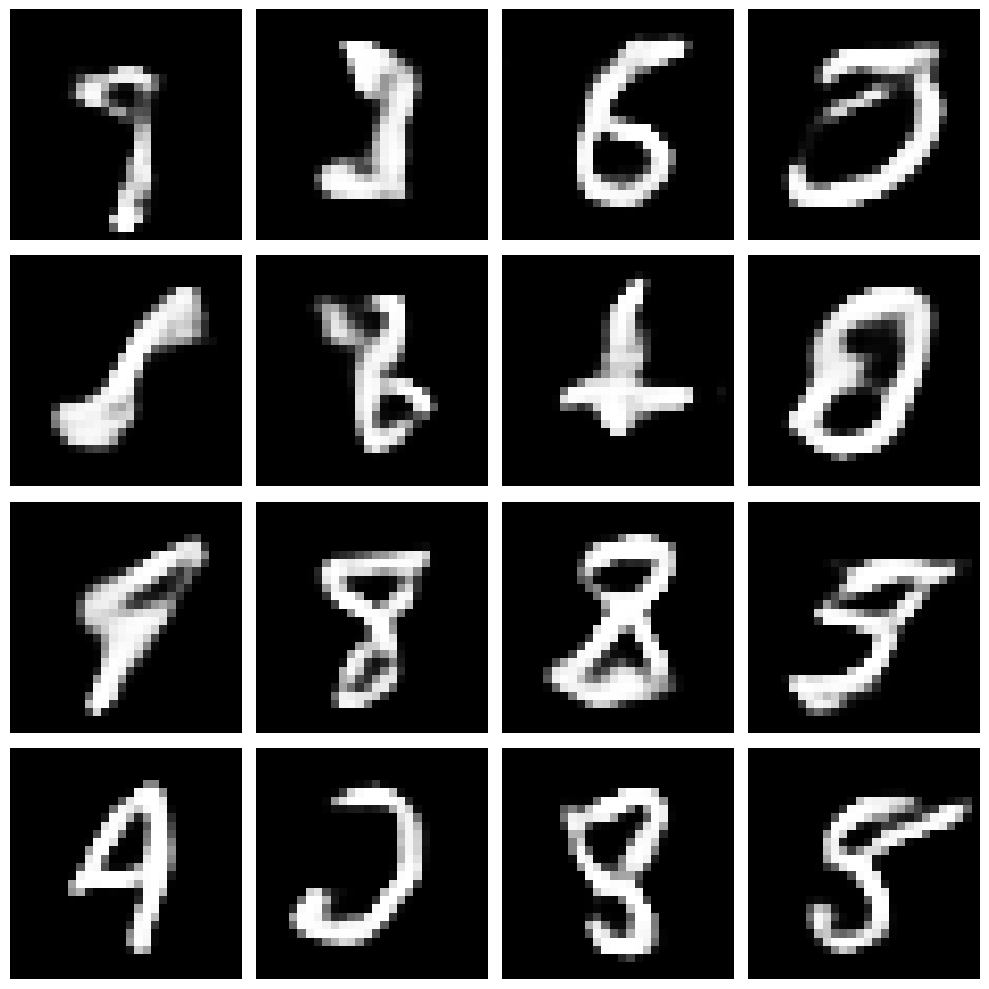

In [28]:
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100) 
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)



**1. Explica qué hacen las siguientes líneas de código:**

```python
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100)
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)
```

Este código mide el tiempo de entrenamiento mediante una instancia de la clase ElapsedTimer, entrena el modelo GAN, imprime el tiempo transcurrido y genera y muestra gráficos de imágenes reales y generadas. 

En mayor detalle:
    - La linea timer = ElapsedTimer(): Crea una instancia de la clase ElapsedTimer, iniciando el temporizador y la medición del tiempo.
    - La linea train(train_epochs=1000, batch_size=256, save_interval=100): Llama a la función train con los parámetros especificados. Inicia el proceso de entrenamiento de la red adversaria para un total de 1000 épocas, con un batch_size de 256 y guardando las imágenes generadas cada 100 épocas.
    - La linea timer.elapsed_time(): Aquí se llama al método elapsed_time() de la instancia ElapsedTimer. Calcula e imprimer el tiempo transcurrido desde que se inició el temporizador. 
    - La linea plot_images(fake=True): Llama a la función plot_images() para generar y mostrar gráficos de las imágenes generadas. El parámetro fake=True indica que la función debe mostrar las imágenes generadas por el modelo GAN.
    - La linea plot_images(fake=False, saveToFile=True):  Llama nuevamente a la función plot_images() para graficar imágenes reales y además indica que las imágenes deben guardarse en un archivo.
   


**2. Escribe el código necesario para mostrar las imágenes generadas en la última iteración y muestra los resultados:**

1/1 [==============================] - 0s 18ms/step


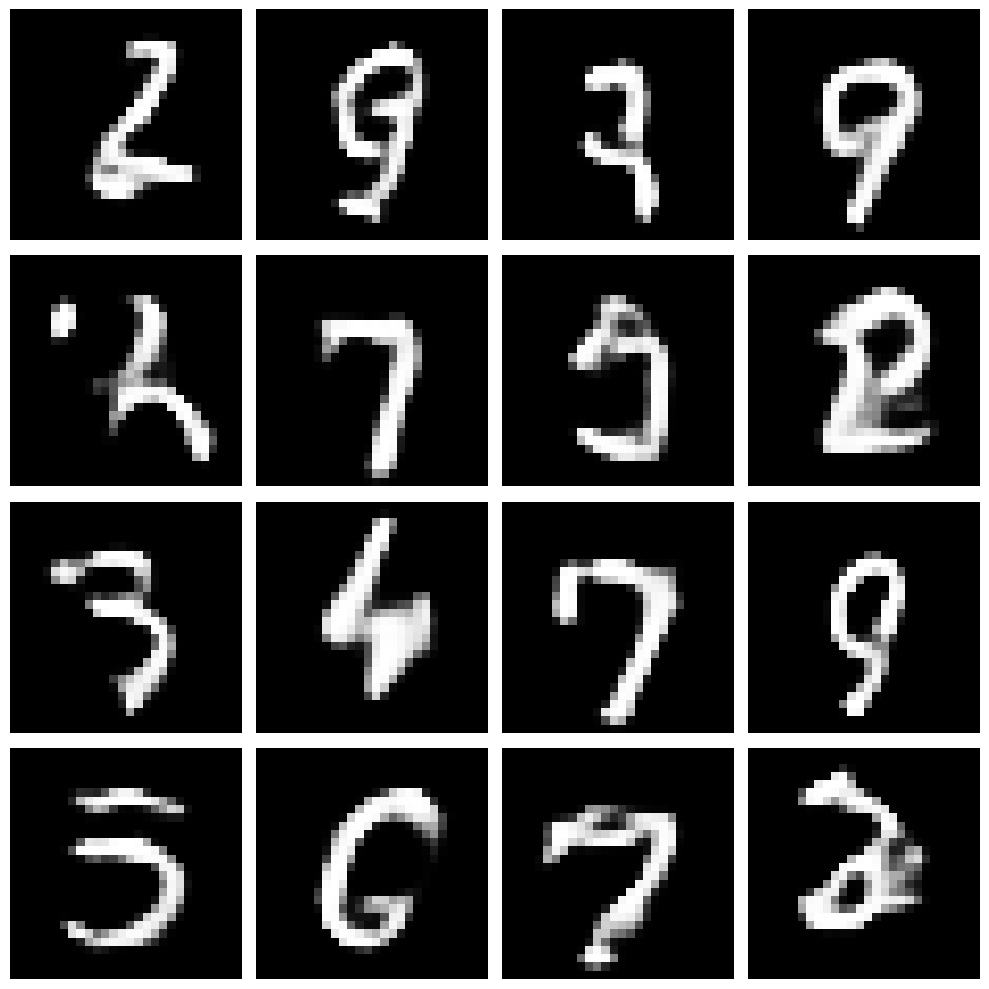

In [29]:
plot_images(fake=True, epoch=1000) #Serían las imágenes generadas en la última epoch = 1000

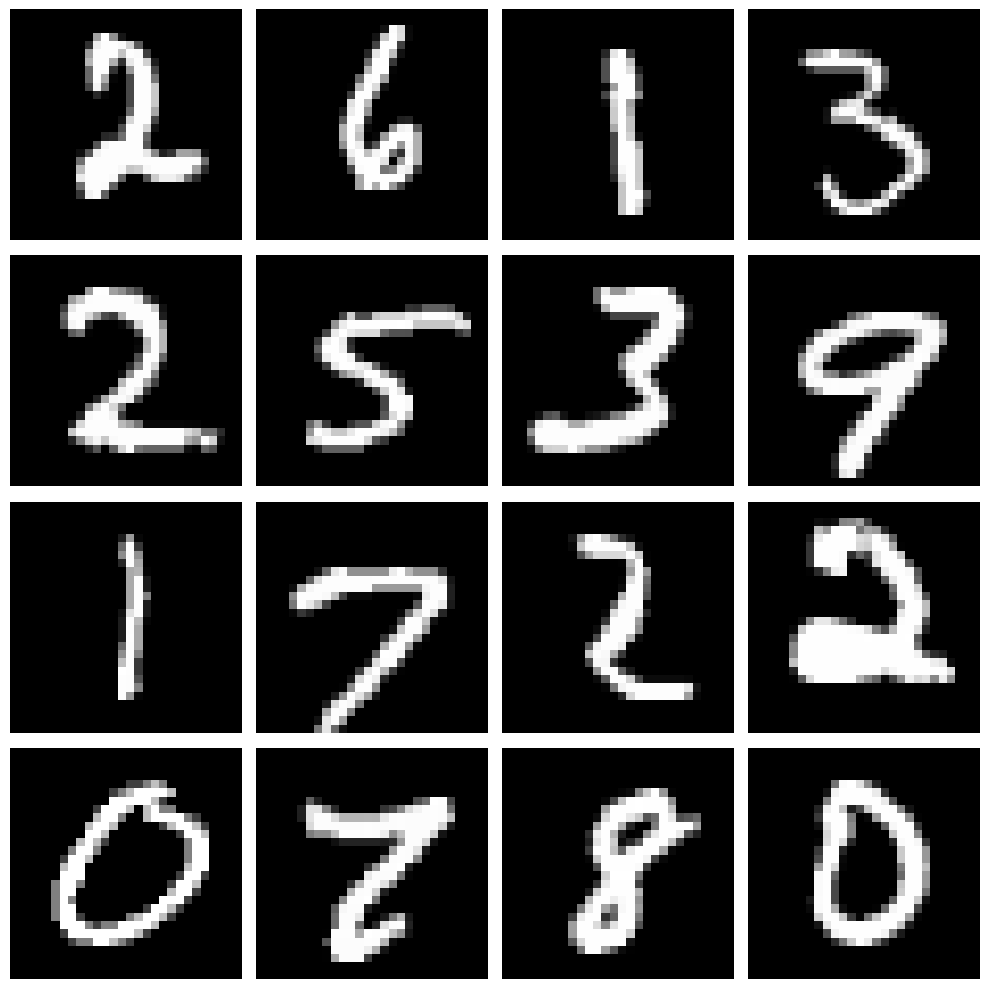

In [30]:
plot_images(fake=False, epoch=1000) #Las imagenes reales correspondientes a esa epoch

# Referencias consultadas:

* https://towardsdatascience.com/keywords-to-know-before-you-start-reading-papers-on-gans-8a08a665b40c
* https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
* Modelos Generativos - Jordi de la Torre Gallart
* https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://towardsdatascience.com/batch-normalisation-in-deep-neural-network-ce65dd9e8dbf
* https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
* https://medium.com/swlh/gan-generative-adversarial-network-3706ebfef77e
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://www.techtarget.com/searchenterpriseai/feature/CNN-vs-GAN-How-are-they-different
* Fundamentos de las redes neuronales convolucionales por Jordi Casas Roma y Anna Bosch Rue
* https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
* https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
* https://keras.io/api/optimizers/rmsprop/
* https://keras.io/api/models/model_training_apis/